In [1]:
import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

%pylab inline

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_df = pd.read_csv('./智能硬件语音控制的时频图分类挑战赛公开数据/train.csv')
train_df['path'] = './智能硬件语音控制的时频图分类挑战赛公开数据/train/' + train_df['image']
# np.random.shuffle(train_path)

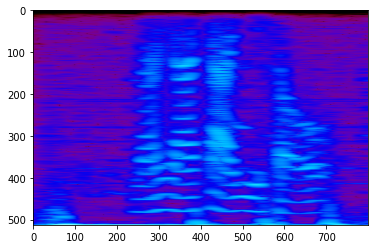

In [3]:
plt.imshow(cv2.imread(train_df['path'].iloc[0]))

In [4]:
test_df = pd.read_csv('智能硬件语音控制的时频图分类挑战赛公开数据/提交示例.csv')
test_df['path'] = '智能硬件语音控制的时频图分类挑战赛公开数据/test/' + test_df['image'] 

In [5]:
class XunFeiDataset(Dataset):
    def __init__(self, img_path, label, transform=None):
        self.img_path = img_path
        self.label = label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        img = cv2.imread(self.img_path[index])            
        img = img.astype(np.float32)
        
        img /= 255.0
        img -= 1
        
        if self.transform is not None:
            img = self.transform(image = img)['image']
        img = img.transpose([2,0,1])
        
        return img,torch.from_numpy(np.array(self.label[index]))
    
    def __len__(self):
        return len(self.img_path)

In [6]:
class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
                
        model = models.resnet18(True)
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        model.fc = nn.Linear(512, 24)
        self.resnet = model
        
    def forward(self, img):        
        out = self.resnet(img)
        return out

In [7]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 40 == 0:
            print(loss.item())
            
        train_loss += loss.item()
    
    return train_loss/len(train_loader)
            
def validate(val_loader, model, criterion):
    model.eval()
    
    val_acc = 0.0
    
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)
            
            val_acc += (output.argmax(1) == target).sum().item()
            
    return val_acc / len(val_loader.dataset)

def predict(test_loader, model, criterion):
    model.eval()
    val_acc = 0.0
    
    test_pred = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(test_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            test_pred.append(output.data.cpu().numpy())
            
    return np.vstack(test_pred)

In [8]:
import albumentations as A

train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_df['path'].values[:-200], train_df['label'].values[:-200],
            A.Compose([
            # A.Resize(300, 300),
            A.RandomCrop(450, 750),
            # A.HorizontalFlip(p=0.5),
            # A.RandomContrast(p=0.5),
            # A.RandomBrightnessContrast(p=0.5),
        ])
    ), batch_size=5, shuffle=True, num_workers=1, pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_df['path'].values[-200:], train_df['label'].values[-200:],
            A.Compose([
            # A.Resize(300, 300),
            A.RandomCrop(450, 750),
            # A.HorizontalFlip(p=0.5),
            # A.RandomContrast(p=0.5),
        ])
    ), batch_size=2, shuffle=False, num_workers=1, pin_memory=False
)

# test_loader = torch.utils.data.DataLoader(
#     XunFeiDataset(test_df['path'].values,
#             A.Compose([
#             # A.Resize(300, 300),
#             A.RandomCrop(130, 450),
#             # A.HorizontalFlip(p=0.5),
#             # A.RandomContrast(p=0.5),
#         ])
#     ), batch_size=10, shuffle=False, num_workers=1, pin_memory=False
# )


In [9]:
model = XunFeiNet()
model = model.to('cuda')
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

In [10]:
for _  in range(20):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_acc = validate(val_loader, model, criterion)
    
    print(train_loss, val_acc)

3.2952709197998047
3.5732827186584473
3.3863601684570312
3.0715525150299072
3.34063982963562
3.563676357269287
3.212756395339966
3.4869418144226074
3.3817219734191895
3.3365893363952637
3.3420841381298545 0.05
3.4887099266052246
3.2452454566955566
3.41926646232605
3.33351469039917
3.3366904258728027
3.006769895553589
3.4384353160858154
3.0757548809051514
3.352080821990967
3.0097222328186035
3.2620487403134146 0.06
3.102877140045166
2.9085853099823
3.382877826690674
3.265240430831909
3.0676724910736084
3.2301926612854004
3.5652313232421875
3.115288257598877
2.991442918777466
3.039703607559204
3.2347688962990335 0.045
3.1707894802093506
2.871647357940674
3.009859085083008
3.3115081787109375
2.947039842605591
3.3750014305114746
3.042001247406006
3.3454031944274902
3.6425909996032715
3.3779501914978027
3.1578618517878123 0.06
3.0617623329162598
2.768014430999756
3.212258815765381
3.2218117713928223
2.875659465789795
2.817971706390381
3.1301517486572266
3.4053292274475098
3.065016984939575


In [11]:
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_df['path'].values, [0] * test_df.shape[0],
            A.Compose([
            # A.Resize(300, 300),
            A.RandomCrop(450, 750),
            # A.HorizontalFlip(p=0.5),
            # A.RandomContrast(p=0.5),
        ])
    ), batch_size=10, shuffle=False, num_workers=1, pin_memory=False
)

pred = None

for _ in range(5):
    if pred is None:
        pred = predict(test_loader, model, criterion)
    else:
        pred += predict(test_loader, model, criterion)

# Test

In [12]:
submit = pd.DataFrame(
    {
        'image': [x.split('/')[-1] for x in test_df['path'].values],
        'label': pred.argmax(1)
})

In [13]:
# test_df = pd.read_csv('提交示例.csv')
# test_df['label'] = pred.argmax(1)

# submit = submit.sort_values(by='id')
# test_df.to_csv('submit2.csv', index=None)

In [14]:
submit.to_csv('sub.csv', index=None)